# PROGETTO MASTER DATA SCIENCE
## COMPUTATIONAL STATISTICS & MACHINE LEARNING
## ANDREA NAVA - Marzo 2022
***

## SOMMARIO
1. Introduzione
2. Statistiche descrittive
3. Esplorazione: il test D di Somers
4. Modelli di training: Regressione Logistica
5. Preparazione dati per il clustering
6. Modelli di traning: K-Means
7. Modelli di training: Clustering Agglomerativo
8. Conclusioni
##

***
### 1. Introduzione

Il **Global Village** è una delle principali attrazioni di Dubai (UAE). Si tratta di un parco a tema, focalizzato sul multiculturalismo. Unico nel suoa genere, il parco è diviso in padiglioni nei quali sono presenti ristoranti e mercati relativi a un differente Paese o cultura. Oltre ai padilgioni, sono presenti aree dedicate all'intrattenimento, come palchi per concerti, spettacoli e attrazioni.</br>
Il parco, attivo da ottobre ad aprile, è frequentato da circa 7 milioni di visitatori a stagione, facendo di esso il **quarto parco tematico più visitato al mondo**, dopo i parchi Disney di Orlando, Anaheim e Tokyo<a href="https://gulfnews.com/uae/new-record-dubai-global-village-is-now-amongst-the-top-four-most-visited-entertainment-destinations-in-the-world-1.69181995" target="_blank"> (1)</a>.

<center><img src="Global-Village-2021.jpg"style="width: 600px;"/>></center>


La direzione del Global Village commissiona su base mensile una survey destinata ai visitatori di cui si conoscono i dati, ovvero coloro che hanno acquistato il biglietto online o che hanno utilizzato il WiFi del parco. Scopo della survey è quello di valutare la soddisisfazione dei visitatori sia a livello complessivo che rispetto ai vari aspetti della loro esperienza, nonché di raccogliere informazioni sui comportamenti e attutudini.

Obiettivo del presente progetto è eseguire un'esplorazione dei dati con tecniche di statistica descrittiva, e di sperimentare quindi alcuni fra gli algoritmi di clusterizzazione dei visitatori studiati durante il corso.

***
### 2. Statistiche descrittive

Per prima cosa, si vuole conoscere come è fatto il dataset a disposizione, relativo alle visite nei mesi di **gennaio e febbraio 2022**. </br>
Comincio con l'importare le librerie necessarie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Per la sez. 3 Esplorazione: il test D di Somers
from scipy.stats import somersd

# Per la sez. 4. Modelli di training: Regressione Logistica
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score, f1_score

# Per la sez. 5 Preparazione dati per il clustering
from sklearn.decomposition import PCA

# Per la sez. 6 Modelli di traning: K-Means
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score
import matplotlib as mp
import collections

# Per la sez. 7
import scipy.cluster.hierarchy as hier

Apro il file contenente i dati. Per maggior comodità ho impostato il file in tre fogli:</br>
* un foglio contenente tutti i dati ("db")
* un foglio contenente solo i valori delle soddisfazioni ("db_sat")
* un foglio contenente solo i dati di spesa ("db_spend")

In [2]:
df_all = pd.read_excel ('GV_Season_26_JAN_FEB.xlsx', sheet_name='db', index_col=0)
df_sat = pd.read_excel ('GV_Season_26_JAN_FEB.xlsx', sheet_name='db_sat', index_col=0)
df_spend = pd.read_excel ('GV_Season_26_JAN_FEB.xlsx', sheet_name='db_spend', index_col=0)

Vediamo come è fatto il dataset totale:

In [3]:
df_all.shape

(3510, 78)

Cominciamo a esplorare:

In [4]:
def hist_total_response_by_gender():
    plt.figure(figsize=(6, 6))
    sns.countplot(x='Gender', data=df_all)
def hist_total_response_by_age():
    plt.figure(figsize=(20, 6))
    sns.countplot(x='Age', data=df_all)
def hist_total_response_by_nationality():
    plt.figure(figsize=(20, 6))
    sns.countplot(x='Nationality', data=df_all, order=pd.value_counts(df_all['Nationality']).iloc[:10].index)

In [5]:
def hist_total_response_by_month():
    plt.figure(figsize=(6, 6))
    sns.countplot(x='Month', data=df_all, order=ord_month)
    plt.show()
def hist_total_response_by_week():
    plt.figure(figsize=(20, 6))
    sns.countplot(x='Week', data=df_all, order=ord_week)
    plt.show()

In [6]:
def hist_total_response_by_ovexp():
    plt.figure(figsize=(6, 6))
    sns.countplot(x='15. Taking everything into account, how would you rate your overall experience?', data=df_all, palette="RdYlGn")
    plt.show()

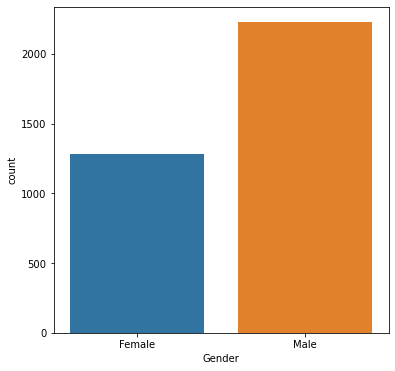

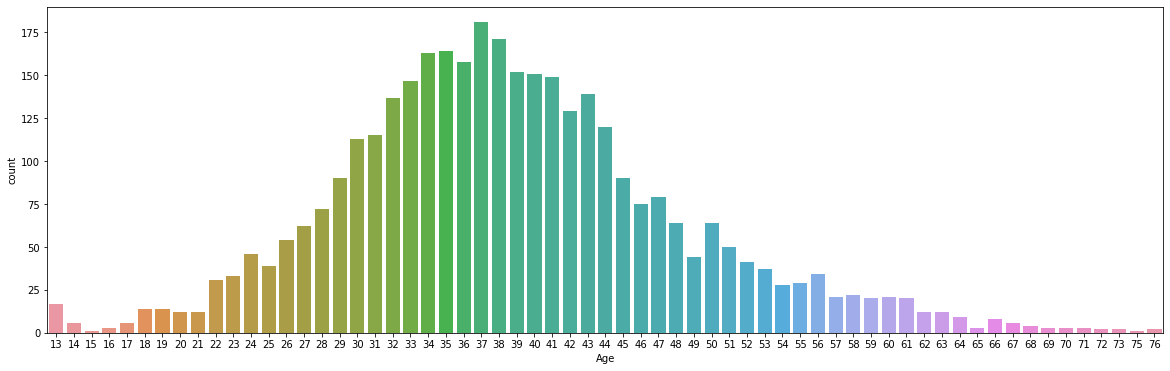

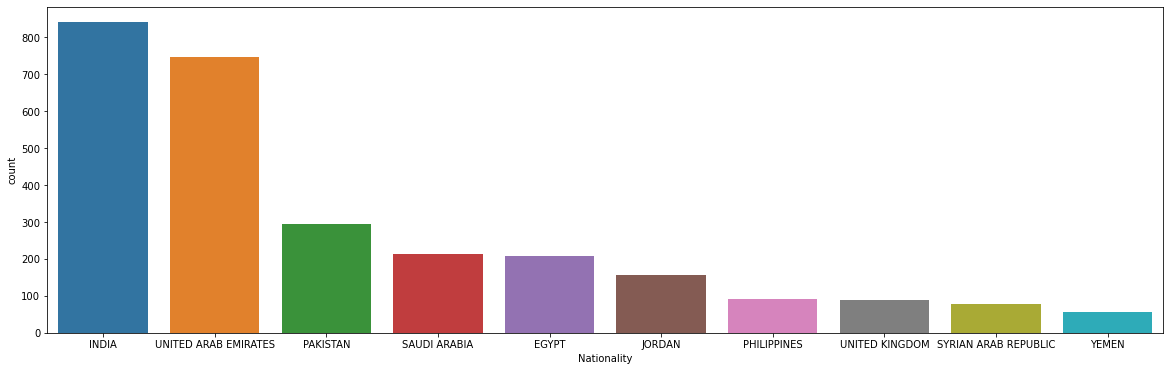

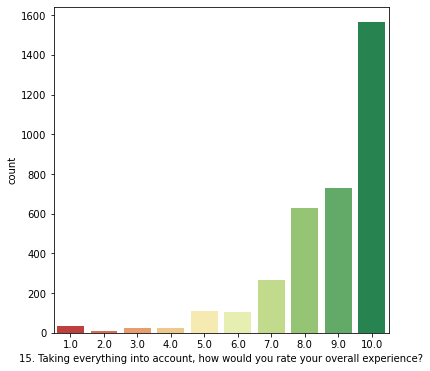

In [7]:
hist_total_response_by_gender()
hist_total_response_by_age()
hist_total_response_by_nationality()
hist_total_response_by_ovexp()

In [8]:
ord_week = sorted(list(set(df_all["Week"])))
ord_month = ['January', 'February']

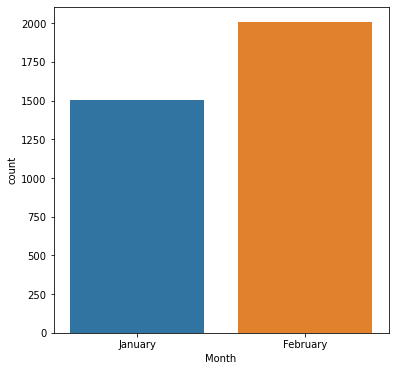

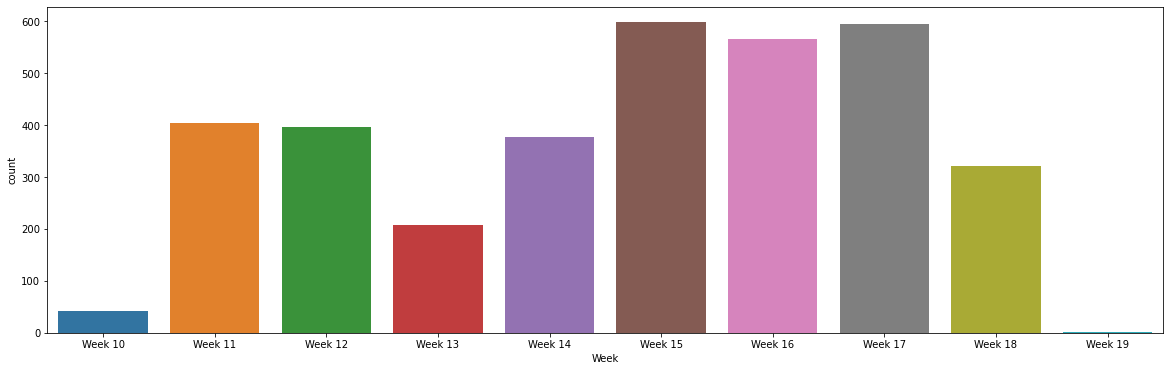

In [9]:
hist_total_response_by_month()
hist_total_response_by_week()

***
### 3. Esplorazione: il test D di Somers

La **D di Somers** è una misura di associazione ordinale tra due possibili variabili casuali dipendenti X e Y.</br>
La D di Somers assume valori compresi tra -1 (quando tutte le coppie di variabili sono in disaccordo) e +1 (quando tutte le coppie di variabili concordano) <a href="https://scipy.github.io/devdocs/reference/generated/scipy.stats.somersd.html" target="_blank"> (2)</a>.</br>
In questo caso, lo scopo dell'analisi è testare **quanto l'NPS (variabile dipendente) sia influenzato dalla soddisfazione nei confronti degli elementi** costituenti l'esperienza.

Per questa analisi utilizzo il foglio contenente solo i dati relativi alle soddisfazioni per i vari aspetti dell'esperienza:</br>
* Net Promoter *<-- variabile dipendente*
* Ticketing experience
* Parking experience
* Access experience
* Check-in experience
* Overall experience
* Dining experience
* Shows experience
* Shopping experience
* Wayfinding
* Facilities & services experience
* Value for money
* Intention to revisit

In [10]:
df_sat.head()

,Net Promoter,Ticketing experience,Parking experience,Access experience,Check-in experience,Overall experience,Dining experience,Shows experience,Shopping experience,Wayfinding,Facilities & services experience,Value for money,Intention to revisit,Month,Age,Week,Day,Gender,UAE vs Abroad
surveyDataId,,,,,,,,,,,,,,,,,,,
05597325-35E3-4F39-930D-E3A874C9EF95,10.0,10.0,10.0,10,10,10.0,9.0,10.0,10.0,10.0,10.0,10,10,February,47,Week 17,2022-02-19,Female,"Yes, I live in the United Arab Emirates"
FA63114A-B303-4AFF-8915-F1D552DFA01B,10.0,10.0,6.0,3,10,9.0,4.0,9.0,8.0,9.0,7.0,8,8,February,39,Week 17,2022-02-18,Male,"Yes, I live in the United Arab Emirates"
C6F2F294-D3FA-43DC-B3AF-8AD8672D132D,8.0,10.0,8.0,9,8,8.0,NaN,5.0,5.0,10.0,8.0,7,3,February,37,Week 17,2022-02-19,Male,"Yes, I live in the United Arab Emirates"
07A500D6-3FD1-4CF8-8447-C6791A7FB171,10.0,10.0,NaN,9,10,10.0,8.0,9.0,8.0,10.0,10.0,10,10,February,39,Week 17,2022-02-20,Male,"No, I live in another country"
61F06759-786F-4828-9E16-D3A6D089CE48,10.0,10.0,10.0,10,10,10.0,NaN,10.0,NaN,10.0,10.0,10,10,February,47,Week 17,2022-02-19,Male,"Yes, I live in the United Arab Emirates"


In [11]:
df_TKT = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,1])
df_PRK = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,2])
df_ACC = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,3])
df_CHK = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,4])
df_OVX = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,5])
df_DIN = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,6])
df_SHW = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,7])
df_SHP = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,8])
df_WAY = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,9])
df_FCS = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,10])
df_VFM = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,11])
df_ITR = pd.crosstab(df_sat.iloc[:,0],df_sat.iloc[:,12])

Calcolo i valori della D di Somers per ciascuna soddisfazione nei confronti dell'NPS.

In [12]:
res_TKT = somersd(df_TKT)
res_PRK = somersd(df_PRK)
res_ACC = somersd(df_ACC)
res_CHK = somersd(df_CHK)
res_OVX = somersd(df_OVX)
res_DIN = somersd(df_DIN)
res_SHW = somersd(df_SHW)
res_SHP = somersd(df_SHP)
res_WAY = somersd(df_WAY)
res_FCS = somersd(df_FCS)
res_VFM = somersd(df_VFM)
res_ITR = somersd(df_ITR)

In [13]:
df_sat.drop(df_sat.columns[[0, 13, 14, 15, 16, 17, 18]], axis = 1, inplace = True)

In [14]:
res_names = list(df_sat.columns)

In [15]:
res_STAT = [res_TKT.statistic, res_PRK.statistic, res_ACC.statistic, res_CHK.statistic, res_OVX.statistic, res_DIN.statistic, res_SHW.statistic, res_SHP.statistic, res_WAY.statistic, res_FCS.statistic, res_VFM.statistic, res_ITR.statistic]
res_PVAL = [res_TKT.pvalue, res_PRK.pvalue, res_ACC.pvalue, res_CHK.pvalue, res_OVX.pvalue, res_DIN.pvalue, res_SHW.pvalue, res_SHP.pvalue, res_WAY.pvalue, res_FCS.pvalue, res_VFM.pvalue, res_ITR.pvalue]

In [16]:
res_ALL = pd.DataFrame({'D (NPS)' : res_STAT, 'p-value' : res_PVAL})
res_ALL.index = res_names
print(res_ALL)

                                   D (NPS)        p-value
Ticketing experience              0.372163  1.213579e-119
Parking experience                0.387801   5.890818e-96
Access experience                 0.367414  9.778739e-106
Check-in experience               0.452106  4.529645e-168
Overall experience                0.710192   0.000000e+00
Dining experience                 0.502143  7.031609e-189
Shows experience                  0.518347  1.729899e-174
Shopping experience               0.533626  1.060462e-221
Wayfinding                        0.416086  1.497625e-136
Facilities & services experience  0.520253  8.372584e-221
Value for money                   0.398072  1.357148e-117
Intention to revisit              0.655257   0.000000e+00


I valori del p-value sono tutti prossimi allo zero. Preparo quindi una heatmap.

In [17]:
res_HTMP = pd.DataFrame({'D (NPS)' : res_STAT})
res_HTMP.index = res_names

<AxesSubplot:>

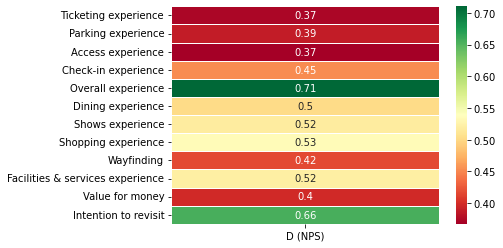

In [18]:
sns.heatmap(res_HTMP, cmap="RdYlGn", linewidths=.8, annot=True)

***
### 4. Modelli di training: Regressione Logistica

Il modello di **regressione logistica** viene utilizzato quando si vuole analizzare la relazione causale tra una variabile dipendente dicotomica e una o più variabili indipendenti quantitative. È un metodo di **classificazione**.

La regressione logistica è definita come:</br>
$$y = f(z) = \frac{1}{1+e^{-z}} = \frac{e^z}{1+e^z}
$$

Con il set di dati a disposizione, provo a verificare quanto una soddisfazione positiva nella visita a Global Village dipenda dalle variabili indipendenti (genere, età, nazionalità).

In [19]:
df_sat = pd.read_excel ('GV_Season_26_JAN_FEB.xlsx', sheet_name='db_sat', index_col=0)
X = df_sat

In [20]:
X.drop(df_sat.columns[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]], axis = 1, inplace = True)

In [21]:
X.head()

,Overall experience,Age,Gender,UAE vs Abroad
surveyDataId,,,,
05597325-35E3-4F39-930D-E3A874C9EF95,10.0,47,Female,"Yes, I live in the United Arab Emirates"
FA63114A-B303-4AFF-8915-F1D552DFA01B,9.0,39,Male,"Yes, I live in the United Arab Emirates"
C6F2F294-D3FA-43DC-B3AF-8AD8672D132D,8.0,37,Male,"Yes, I live in the United Arab Emirates"
07A500D6-3FD1-4CF8-8447-C6791A7FB171,10.0,39,Male,"No, I live in another country"
61F06759-786F-4828-9E16-D3A6D089CE48,10.0,47,Male,"Yes, I live in the United Arab Emirates"


Sono sicuramente presenti dei null, che vado ad eliminare.

In [22]:
X = X.dropna()

In [23]:
X.shape

(3502, 4)

La variabile dipendente deve essere dicotomica, io invece ho valori da 1 a 10 (scala di Likert). Voglio quindi assegnare il valore 0 a coloro che indicano un grado di soddisfazione da 1 a 8, e il valore 1 a chi indica 9 o 10.

In [24]:
X['Overall experience'].values[X['Overall experience'] < 9] = 0
X['Overall experience'].values[X['Overall experience'] >= 9] = 1

In [25]:
def hist_total_response_by_sat():
    plt.figure(figsize=(6, 6))
    sns.countplot(x='Overall experience', data=X, palette="RdYlGn")
    plt.show()

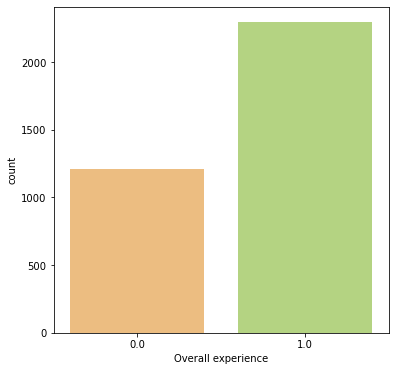

In [26]:
hist_total_response_by_sat()

Sistemo anche le altre variabili.

In [27]:
X['Gender'].values[X['Gender'] == 'Female'] = 0
X['Gender'].values[X['Gender'] == 'Male'] = 1
X['UAE vs Abroad'].values[X['UAE vs Abroad'] == 'Yes, I live in the United Arab Emirates'] = 0
X['UAE vs Abroad'].values[X['UAE vs Abroad'] == 'No, I live in another country'] = 1

In [28]:
X.head()

,Overall experience,Age,Gender,UAE vs Abroad
surveyDataId,,,,
05597325-35E3-4F39-930D-E3A874C9EF95,1.0,47,0,0
FA63114A-B303-4AFF-8915-F1D552DFA01B,1.0,39,1,0
C6F2F294-D3FA-43DC-B3AF-8AD8672D132D,0.0,37,1,0
07A500D6-3FD1-4CF8-8447-C6791A7FB171,1.0,39,1,1
61F06759-786F-4828-9E16-D3A6D089CE48,1.0,47,1,0


In [29]:
pd.crosstab(X['Gender'], X['Overall experience'], margins=True, margins_name="Total")

Overall experience,0.0,1.0,Total
Gender,,,
0,407,874,1281
1,800,1421,2221
Total,1207,2295,3502


In [30]:
pd.crosstab(X['Age'], X['Overall experience'], margins=True, margins_name="Total")

Overall experience,0.0,1.0,Total
Age,,,
13,7,10,17
14,2,4,6
15,0,1,1
16,1,2,3
17,2,4,6
...,...,...,...
72,0,2,2
73,0,2,2
75,0,1,1


In [31]:
pd.crosstab(X['UAE vs Abroad'], X['Overall experience'], margins=True, margins_name="Total")

Overall experience,0.0,1.0,Total
UAE vs Abroad,,,
0,995,1878,2873
1,212,417,629
Total,1207,2295,3502


A occhio nudo non sembra ci siano grandi correlazioni fa le variabili demografiche e la soddisfazione:

<AxesSubplot:xlabel='Overall experience', ylabel='count'>

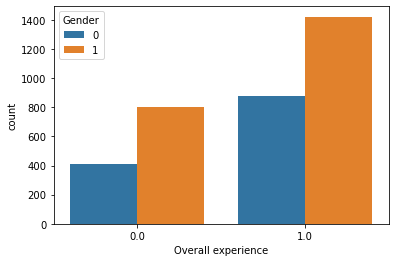

In [32]:
sns.countplot(x='Overall experience',hue='Gender',data=X)

<AxesSubplot:xlabel='Overall experience', ylabel='count'>

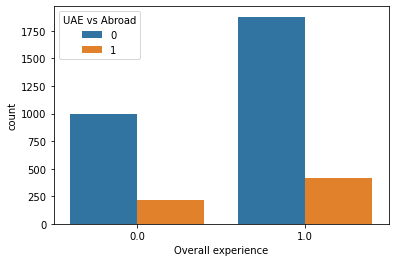

In [33]:
sns.countplot(x='Overall experience',hue='UAE vs Abroad',data=X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('Overall experience',axis=1), 
                                                    X['Overall experience'], test_size=0.30, 
                                                    random_state=45)


In [35]:
logit_cls = LogisticRegression(max_iter=1000)
logit_cls.fit(X_train,y_train)
predictions = logit_cls.predict(X_test)

In [36]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       359
         1.0       0.66      1.00      0.79       692

    accuracy                           0.66      1051
   macro avg       0.33      0.50      0.40      1051
weighted avg       0.43      0.66      0.52      1051



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
y_scores = cross_val_predict(logit_cls, X_train, y_train, cv = 10, method='decision_function')

In [38]:
prec, recall, soglia = precision_recall_curve(y_train, y_scores)

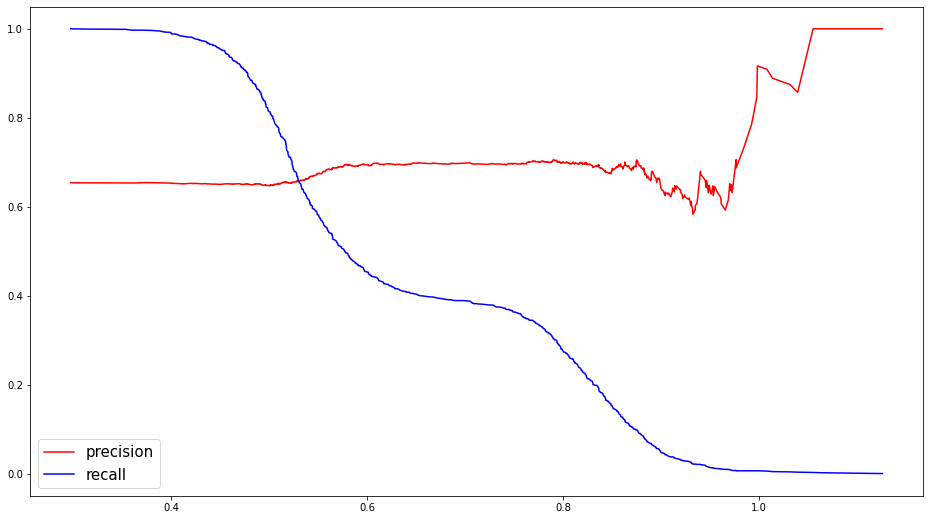

In [39]:
fig_prc = plt.figure(figsize=(16,9))
ax = fig_prc.add_subplot()
ax.plot(soglia, prec[:-1], 'r', label = 'precision')
ax.plot(soglia, recall[:-1], 'b', label = 'recall')
ax.legend(fontsize=15)

Text(0, 0.5, 'Precision')

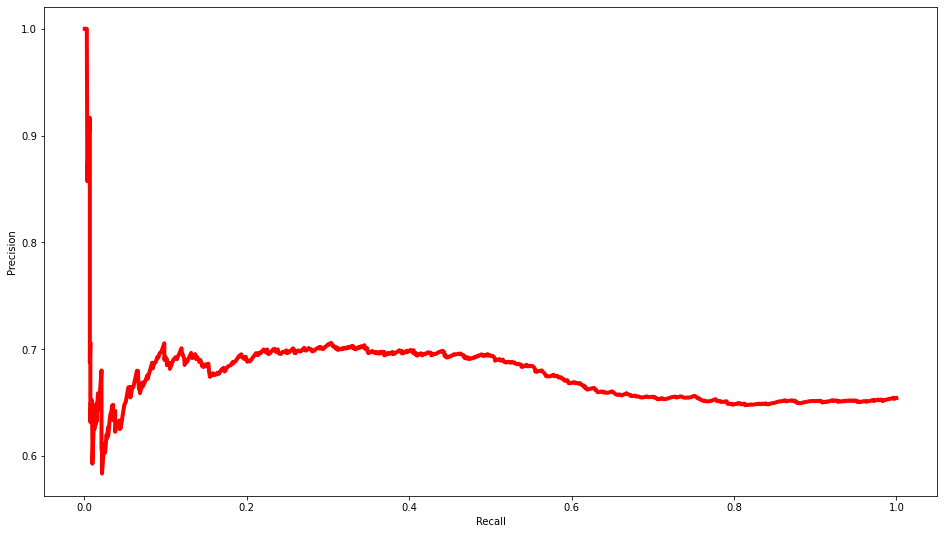

In [40]:
fig_prf = plt.figure(figsize=(16,9))
ax = fig_prf.add_subplot()
ax.plot(recall[:-1], prec[:-1], 'r', label = 'precision', lw = 4)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

Provo a portare la soglia a un valore pari a 0,5:

In [41]:
soglia_prec_50 = soglia[np.argmax(prec >= 0.5)]
y_predicted_score = y_scores >= soglia_prec_50
print(precision_score(y_train, y_predicted_score), recall_score(y_train, y_predicted_score), f1_score(y_train, y_predicted_score))

0.6540187678498572 1.0 0.790823877651702


***
### 5. Preparazione dati per il clustering

Per provare ad effettuare una **clusterizzazione**, ho bisogno di avere solo due variabili, di modo che sia possibile rappresentarle su un diagramma cartesiano. Devo quindi ridurre la complessità del mio dataset, che attualmente comprende 11 variabili (le stesse dell'analisi precedente meno le due che ipotizzo essere dipendenti dalle altre, ovvero il Net Promoter e la Overall Experience).

Riparto quindi dal foglio con le sole colonne relative alle soddisfazioni per gli elementi costitutivi dell'esperienza, eliminando le variabili che non voglio portare nell'analisi.

In [42]:
df_sat = pd.read_excel ('GV_Season_26_JAN_FEB.xlsx', sheet_name='db_sat', index_col=0)
X = df_sat.iloc[:, np.r_[1:13]]

In [43]:
X.head()

,Ticketing experience,Parking experience,Access experience,Check-in experience,Overall experience,Dining experience,Shows experience,Shopping experience,Wayfinding,Facilities & services experience,Value for money,Intention to revisit
surveyDataId,,,,,,,,,,,,
05597325-35E3-4F39-930D-E3A874C9EF95,10.0,10.0,10,10,10.0,9.0,10.0,10.0,10.0,10.0,10,10
FA63114A-B303-4AFF-8915-F1D552DFA01B,10.0,6.0,3,10,9.0,4.0,9.0,8.0,9.0,7.0,8,8
C6F2F294-D3FA-43DC-B3AF-8AD8672D132D,10.0,8.0,9,8,8.0,NaN,5.0,5.0,10.0,8.0,7,3
07A500D6-3FD1-4CF8-8447-C6791A7FB171,10.0,NaN,9,10,10.0,8.0,9.0,8.0,10.0,10.0,10,10
61F06759-786F-4828-9E16-D3A6D089CE48,10.0,10.0,10,10,10.0,NaN,10.0,NaN,10.0,10.0,10,10


In [44]:
X.shape

(3510, 12)

Ora ho solo i dati che mi interessano. Tuttavia sono presenti dei dati mancanti, che preferisco eliminare.

In [45]:
X = X.dropna()
X

,Ticketing experience,Parking experience,Access experience,Check-in experience,Overall experience,Dining experience,Shows experience,Shopping experience,Wayfinding,Facilities & services experience,Value for money,Intention to revisit
surveyDataId,,,,,,,,,,,,
05597325-35E3-4F39-930D-E3A874C9EF95,10.0,10.0,10,10,10.0,9.0,10.0,10.0,10.0,10.0,10,10
FA63114A-B303-4AFF-8915-F1D552DFA01B,10.0,6.0,3,10,9.0,4.0,9.0,8.0,9.0,7.0,8,8
EBDDFB6D-AAB0-4955-8002-79FE197FDC2A,10.0,10.0,10,10,10.0,10.0,10.0,10.0,10.0,10.0,10,10
BB63AD60-AC9E-4FEC-A41C-DAB1A633880A,10.0,10.0,10,9,10.0,9.0,10.0,10.0,10.0,10.0,9,10
32AB91E8-AFDD-45DC-9B15-2BA50B09050E,10.0,7.0,7,8,8.0,9.0,9.0,7.0,9.0,9.0,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...
D9492FB2-431A-4540-9405-C835DDFD6D1C,10.0,6.0,5,8,10.0,6.0,8.0,6.0,6.0,10.0,6,10
D3240562-1ABF-49BF-8148-2E9C8242B765,10.0,10.0,10,10,10.0,10.0,10.0,10.0,10.0,10.0,10,10
E7AE8261-158F-43BC-A603-6861CDA002E5,8.0,8.0,6,8,8.0,6.0,10.0,7.0,8.0,8.0,7,9


In [46]:
X.shape

(2279, 12)

Provo a ridurre la complessità del dataset eseguendo l'**analisi delle componenti principali (PCA)**, tecnica di analisi multivariata che ha proprio come obiettivo una riduzione della dimensionalità. Voglio quindi ridurre un numero elevato di variabili, in questo caso undici, a due variabili "latenti", limitando il più possibile la perdita di informazioni.

In [47]:
pca = PCA(n_components = 2, random_state=1)
X_pca = pca.fit_transform(X)

In [48]:
print('Explained Variance Ratio : ' + str(pca.explained_variance_ratio_.cumsum()[1]))

Explained Variance Ratio : 0.6330681096407791


La varianza spiegata dalla PCA è il 63% del totale, un valore piuttosto scarso. *In situazioni normali non sarebbe saggio proseguire con questo parametro, pertanto quanto segue avrà scopo puramente dimostrativo.*

***
### 6. Modelli di traning: K-Means

L'algoritmo **K-Means** raggruppa i dati cercando di separare i campioni in n gruppi di uguale varianza, minimizzando l'inerzia (o somma dei quadrati) all'interno del cluster. Questo algoritmo richiede che il numero di cluster sia specificato.

$$ \sum_{i=1}^{K}\sum_{x_j \in C_{i}}||x_j - \mu_{i}||^2
$$


L'algoritmo funziona nel modo seguente: 
1) Posiziona i centroidi (ovvero le "medie" dei cluster) in modo casuale 
2) Etichetta le istanze in base al centroide più vicino (distanza euclidea)
3) Aggiorna i centroidi e procede fino a quando i centroidi smettono di muoversi 

L'algoritmo è garantito per convergere in un numero finito di passi. Ma potrebbe non convergere alla soluzione giusta: a seconda delll'inizializzazione dei centroidi, il risultato potrebbe non essere lo stesso se si esegue questo algoritmo più volte. Fortunatamente, il modello K-Means in Scikit-Learn ha implementato una versione più avanzata di questo algoritmo, chiamata **K-Means++**.</br>
Il K-Means++ posiziona i centroidi iniziali ben distanziati l'uno dall'altro, il che porta a una convergenza più veloce e un risultato più coerente.


Come prima cosa, vado a definire il numero dei cluster con il **metodo Elbow** (gomito).

In [49]:
X_pca.shape

(2279, 2)

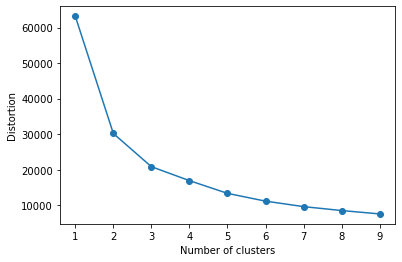

In [50]:
distortions = []
for i in np.arange(1,10):
    km = KMeans(n_clusters= i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X_pca)
    y_km = km.predict(X_pca)
    distortions.append(km.inertia_)
plt.plot(np.arange(1,10),distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Il "gomito" non è visibile molto chiaramente, ma sembra che dal valore k = 3 la curva si stabilizzi.

Rilancio quindi il modello con 3 cluster.

In [51]:
km = KMeans(
    n_clusters=3,
    init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

km = km.fit(X_pca)
y = km.predict(X_pca)

In [52]:
print('Risultato finale modello K-Means: ')
print(collections.Counter(y))

Risultato finale modello K-Means: 
Counter({1: 1108, 0: 884, 2: 287})


È importante ora valutare la qualità del clustering in corso. Il **Silhouette Coefficient** è un esempio di tale valutazione, laddove un punteggio più alto del Silhouette Coefficient significa un modello con cluster meglio definiti.</br>
Il Silhouette Coefficient è definito per ogni campione ed è composto da due punteggi:
**a**: distanza media tra un campione e tutti gli altri punti della stessa classe
**b**: distanza media tra un campione e tutti gli altri punti nel cluster più vicino
Il coefficiente Silhouette s per un singolo campione è quindi dato come:

$$ s(i) = \frac{b(i) - a(i)}{max(a(i),b(i))} $$

Il Silhouette Coefficient per un insieme di campioni è dato dalla media del Silhouette Coefficient per ogni campione. 

Il Silhouette Coefficient può variare tra -1 e +1. Il valore migliore è 1 e il valore peggiore è -1. I valori vicini allo 0 indicano cluster sovrapposti. I valori negativi indicano generalmente che un campione è stato assegnato al cluster sbagliato, poiché un cluster diverso è più simile.

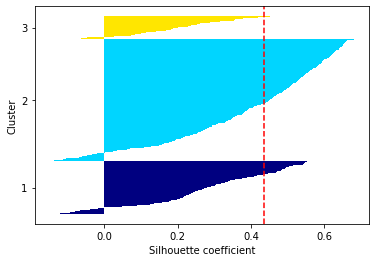

In [53]:
cluster_labels = np.array([0,1,2]) #array di etichette
n_clusters = 3 #numero dei cluster indicato dal metodo Elbow
silhouette_vals =  silhouette_samples(X_pca, km.labels_, metric='euclidean')# silhoutte per campione
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels): # per ogni cluster
    c_silhouette_vals = silhouette_vals[y_km == c] #get the s(i) for samples of cluster c
    c_silhouette_vals.sort() #sort in-place the s(i)
    y_ax_upper += len(c_silhouette_vals)
    color = mp.cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.show()

Purtroppo il risultato non è molto soddisfacente.

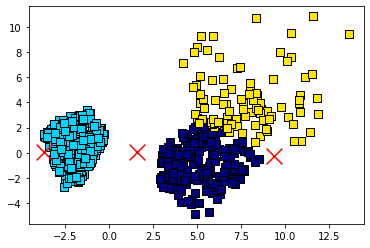

In [54]:
for i, c in enumerate(cluster_labels):
    plt.scatter(X_pca[y_km == c, 0],
            X_pca[y_km == c, 1],
            s=50,
            color = mp.cm.jet(float(i) / n_clusters),
            edgecolor='black',
            marker='s',
            label=str(c))

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='x', c='red', label='centroids')

Estendo ora la classificazione ai valori originali (X).

In [55]:
km_final = KMeans(
    n_clusters=3,
    init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

km_final = km.fit(X)
y_final = km_final.predict(X)

In [56]:
print('Risultato finale modello K-Means (no PCA): ')
print(collections.Counter(y_final))

Risultato finale modello K-Means (no PCA): 
Counter({1: 1116, 2: 887, 0: 276})


***
### 7. Modelli di training: Clustering Agglomerativo

L'algoritmo di **Clustering Agglomerativo** consente di tracciare dendrogrammi, grafici utili sia per interpretare il risutato del clustering, che per individuare il miglior numero di cluster, senza quindi usare il metodo Elbow.
Il funzionamento pevede l'assegnazione ad ogni osservazione di un cluster, e la successiva "fusione" dei cluster in base alla loro distanza, coppia per coppia, iterativamente.

In [57]:
ac = AgglomerativeClustering(n_clusters=3, #numero di cluster
                             affinity='euclidean', #tipo di distanza
                             linkage='complete') #minimizza la distanza massima tra le osservazioni di coppie di cluster
y_ac_X = ac.fit_predict(X_pca)

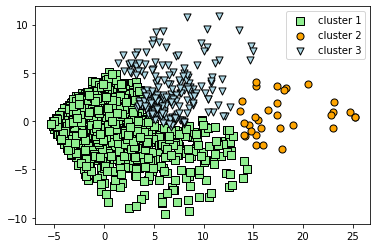

In [58]:
plt.scatter(X_pca[y_ac_X == 0, 0],
            X_pca[y_ac_X== 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X_pca[y_ac_X == 1, 0],
            X_pca[y_ac_X == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X_pca[y_ac_X == 2, 0],
            X_pca[y_ac_X == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')

plt.legend()
plt.show()

Preparo il dendrogramma.

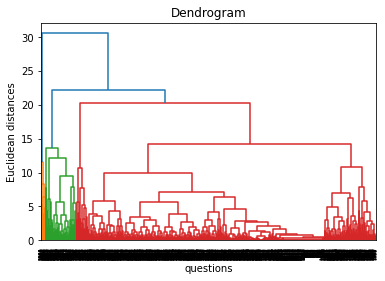

In [59]:
dendrogram = hier.dendrogram(hier.linkage(X_pca, method ='complete'))
plt.title('Dendrogram')
plt.xlabel('questions')
plt.ylabel('Euclidean distances')
plt.show()

model = AgglomerativeClustering(n_clusters = 3, affinity ='euclidean', linkage ='complete')
y = model.fit_predict(X_pca)


Anche in questo caso sembrano essere individuati 3 cluster, anche se le proporzioni sono molto squilibrate a favore di uno dei tre.

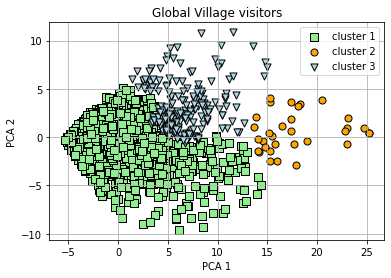

In [60]:
plt.scatter(X_pca[y_ac_X == 0, 0],
            X_pca[y_ac_X== 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X_pca[y_ac_X == 1, 0],
            X_pca[y_ac_X == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X_pca[y_ac_X == 2, 0],
            X_pca[y_ac_X == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.title('Global Village visitors')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid()
plt.show()

In [61]:
print('Risultato finale modello AgglomerativeClustering (Complete): ')
print(collections.Counter(y))


Risultato finale modello AgglomerativeClustering (Complete): 
Counter({0: 2037, 2: 210, 1: 32})


***
### 8. Conclusioni

Come si vedeva dalle analisi preliminari, non emergono dei cluster netti e puliti dal dataset di partenza.</br>
Potrebbe aver senso ritentare l'analisi la prossima stagione, in partenza a ottobre 2022, con un **nuovo questionario** che contenga variabili più differenzianti che non le soddisfazioni per i singoli elementi.